<a href="https://colab.research.google.com/github/haseungchung/Machine-Learning-and-Deep-Learning-Projects/blob/main/Deep%20Learning%20Based%20Signal%20Constellation%20Design%20Using%20an%20Autoencoder/Deep%20Learning%20Based%20Signal%20Constellation%20Design%20Using%20an%20Autoencoder_Hamming_Code_Stable.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
# importing libs
import numpy as np
import tensorflow as tf
import keras
import pandas as pd
import openpyxl
from openpyxl.reader.excel import load_workbook
from numpy.linalg import norm
from keras.layers import Input, Dense, GaussianNoise,Lambda,Dropout, Add
from keras.models import Model
from keras.constraints import max_norm
from keras import regularizers
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam,SGD
from keras import backend as K

In [18]:
# for reproducing result
tf.random.set_seed(2)

In [19]:
# defining parameters
# define (n,k) here for (n,k) autoencoder
# n = n_channel 
# k = log2(M)  ==> so for (7,4) autoencoder n_channel = 7 and M = 2^4 = 16 
M = 16 # number of possible messages for k=4 bits
k = np.log2(M)
k = int(k)
n_channel = 7
bpsk_channel = 4
R = k/n_channel #communication rate, defined as k/n
lr=0.001
max_val=n_channel**2
print ('M:',M,'k:',k,'n:',n_channel)

M: 16 k: 4 n: 7


In [20]:
#generating data of size N
N = 50000
label = np.random.randint(M,size=N) #random integers 1-4  

EbNo_train = 5.01187
noise=np.random.normal(0,np.sqrt(1/(2*R*EbNo_train)),[N,n_channel])

In [21]:
# creating one hot encoded vectors
data=np.zeros([N,M])
for i in range(len(label)):
    data[i][label[i]] = 1

In [22]:
#defining a custom activation function to limit output values
def mapping_to_target_range(x, power_min=-np.sqrt(1), power_max=np.sqrt(1)) : # QAM style
    x02 = K.sigmoid(x)*2 # x in range(0,2)
    scale = ( power_max-power_min )/2
    output = x02*scale + power_min
    return output

# defining autoencoder and its layers
input_signal = Input(shape=(M,))
encoded = Dense(M, activation='relu')(input_signal)
encoded1 = Dense(n_channel, activation='linear')(encoded)
# encoded2 = Dense(n_channel, activation=mapping_to_target_range)(encoded1)
encoded15 = BatchNormalization()(encoded1)
encoded2 = Lambda(lambda x: np.sqrt(n_channel)*K.l2_normalize(x,axis=1))(encoded15)


inputnoise = Input(shape=(n_channel,))
encoded3 = Add()([inputnoise,encoded2])

decoded = Dense(M, activation='relu')(encoded3)
decoded1 = Dense(M, activation='softmax')(decoded)
autoencoder = Model([input_signal, inputnoise], decoded1)
autoencoder.compile(optimizer='adam', loss='categorical_crossentropy')

In [23]:
# printing summary of layers and it's trainable parameters 
print (autoencoder.summary())

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 16)]         0           []                               
                                                                                                  
 dense_4 (Dense)                (None, 16)           272         ['input_4[0][0]']                
                                                                                                  
 dense_5 (Dense)                (None, 7)            119         ['dense_4[0][0]']                
                                                                                                  
 batch_normalization_1 (BatchNo  (None, 7)           28          ['dense_5[0][0]']                
 rmalization)                                                                               

In [60]:
# traning auto encoder
autoencoder.fit([data, noise], data, epochs=70, batch_size=int(M))
autoencoder.fit([data, noise], data, epochs=40, batch_size=int(M*2))
autoencoder.fit([data, noise], data, epochs=60, batch_size=int(M*8))
autoencoder.fit([data, noise], data, epochs=100, batch_size=int(M*16))
autoencoder.fit([data, noise], data, epochs=150, batch_size=int(M*32))
autoencoder.fit([data, noise], data, epochs=250, batch_size=int(M*64))
autoencoder.fit([data, noise], data, epochs=300, batch_size=int(M*128))

Epoch 1/70
3125/3125 [==============================] - 5s 2ms/step - loss: 0.0098
Epoch 2/70
3125/3125 [==============================] - 5s 2ms/step - loss: 0.0118
Epoch 3/70
3125/3125 [==============================] - 6s 2ms/step - loss: 0.0081
Epoch 4/70
3125/3125 [==============================] - 5s 2ms/step - loss: 0.0087
Epoch 5/70
3125/3125 [==============================] - 5s 2ms/step - loss: 0.0094
Epoch 6/70
3125/3125 [==============================] - 5s 2ms/step - loss: 0.0082
Epoch 7/70
3125/3125 [==============================] - 5s 2ms/step - loss: 0.0092
Epoch 8/70
3125/3125 [==============================] - 5s 2ms/step - loss: 0.0072
Epoch 9/70
3125/3125 [==============================] - 6s 2ms/step - loss: 0.0094
Epoch 10/70
3125/3125 [==============================] - 5s 2ms/step - loss: 0.0077
Epoch 11/70
3125/3125 [==============================] - 5s 2ms/step - loss: 0.0075
Epoch 12/70
3125/3125 [==============================] - 5s 2ms/step - loss: 0.0082
E

In [61]:
# isolating the encoder section from full autoencoder
encoder = Model(input_signal, encoded2)

In [62]:
# isolating the decoder section from full autoencoder
deco = autoencoder.layers[-2](encoded3)
deco = autoencoder.layers[-1](deco)
decoder = Model(encoded3, deco)

In [69]:
# Test Data
Ntest = 155555
test_label = np.random.randint(M,size=Ntest)
test_data=np.zeros([Ntest,M])
for i in range(len(test_label)):
    test_data[i][test_label[i]] = 1

In [70]:
# for plotting learned constellation diagram
scatter_plot = []
for i in range(0,M):
    temp = np.zeros(M)
    temp[i] = 1
    scatter_plot.append(encoder.predict(np.expand_dims(temp,axis=0)))
scatter_plot = np.array(scatter_plot)
print (scatter_plot.shape)

(16, 1, 7)


In [71]:
def frange(x, y, jump):
  while x < y:
    yield x
    x += jump

In [72]:
def bitfield(n):
    bits = [1 if digit=='1' else -1 for digit in bin(n-1)[2:]]
    return bits

def BPSKencoding(testlabel,emptymtx): #actually takes in 0-15 not 1-16 so I added a 1
    for ii in range(0,len(testlabel)):
        bits=bitfield(testlabel[ii]+1)
        emptymtx[ii,-len(bits):]=bits
    return emptymtx

# print(test_label[2])
# bpsk[0:3,:]

#works only for 7,4
def Hencode(s): #encoding into a Hamming code when given a matrix s. rows are #data, columns are bit sequence
    # Read in K=4 bits at a time and write out those plus parity bits
        rows,cols=s.shape
        Hcode=np.zeros([rows,cols+3])
        for ii in range(0,s.shape[0]):
            rawcode=s[ii,:]
            Hcode[ii,:]=hamming(s[ii,:])
        return Hcode

def hamming(bits):
    # Return given 4 bits plus parity bits for bits (1,2,3), (2,3,4) and (1,3,4)
    t1 = parity(bits, [0,1,2])
    t2 = parity(bits, [0,2,3])
    t3 = parity(bits, [0,1,3])
    return np.append(bits, [t1, t2, t3]) #again saying, works only for 7,4

def parity(s, indices):
    # Compute the parity bit for the given string s and indicies
    sub = 0
    for i in indices:
        sub = sub+s[i]
    if (sub % 2) == 0:
        return 0
    else:
        return 1

# Hencode(np.array([1, 1, 0, 1]))
# potato=np.where(bpsk_n_signal==-1, 0, bpsk_n_signal)


In [73]:
# calculating BER
# this is optimized BER function so it can handle large number of N
# previous code has another for loop which was making it slow
EbNodB_range = list(frange(-4,8.5,0.5))
ber = [None]*len(EbNodB_range)
bpskber = [None]*len(EbNodB_range)
hamMLDber = [None]*len(EbNodB_range)
bpsk = np.zeros([len(test_label),bpsk_channel])-1
bpsk = BPSKencoding(test_label,bpsk)
ham=Hencode(np.where(bpsk<0,0,bpsk))
ham=2*ham-1

# defining Correlation matrix
labelvalues=(range(0,M)) #if you make this an array, it will return an error. 
hamlabel1 = np.zeros([len(labelvalues),bpsk_channel])-1
hamlabel1=BPSKencoding(labelvalues,hamlabel1)
hamdict=Hencode(np.where(hamlabel1<0,0,hamlabel1))
corr=2*hamdict.T-1

# BER of HAM, Autoencoder
for n in range(0,len(EbNodB_range)):
    EbNo=10.0**(EbNodB_range[n]/10.0)
    noise_std = np.sqrt(1/(2*R*EbNo))
    noise_mean = 0
    no_errors = 0
    nn = Ntest
    noise_test = noise_std * np.random.randn(nn,n_channel)
    encoded_signal = encoder.predict(test_data)
    final_signal = encoded_signal + noise_test
    pred_final_signal =  decoder.predict(final_signal)
    pred_output = np.argmax(pred_final_signal,axis=1)
    no_errors1 = (pred_output != test_label)
    no_errors =  no_errors1.astype(int).sum()
    ber[n] = np.double(no_errors) / np.double(nn)
    
    # Hamming
    hamming_n_signal = ham+noise_test
    scores = np.matmul(hamming_n_signal,corr)
    winningscore = np.argmax(scores,axis=1) #find the index of the highest score, add 1, and thats your prediction for the nn data samples
    ham_errors1 = (winningscore != test_label)#if scores!= test_lacbel
    ham_errors = ham_errors1.astype(int).sum()
    hamMLDber[n] = ham_errors/nn
    
    
    #for BPSK
for n in range(0,len(EbNodB_range)):
    EbNo=10.0**(EbNodB_range[n]/10.0)
    noise_std = np.sqrt(1/(2*k/bpsk_channel*EbNo))
    noise_mean = 0
    no_errors = 0
    nn = Ntest
    noise_bpsk = noise_std * np.random.randn(nn,bpsk_channel)
    bpsk_n_signal = bpsk + noise_bpsk
    bpsk_rec=np.where(bpsk_n_signal>=0,1,bpsk_n_signal)
    bpsk_rec=np.where(bpsk_rec<0,-1,bpsk_rec)
    bpsk_errors = (bpsk_rec != bpsk)
    bpsk_errors =  bpsk_errors.astype(int)
    bpsk_errors2=np.sum(bpsk_errors,axis=1)
    bpsktoterr=np.sum(np.where(bpsk_errors2 != 0, 1, bpsk_errors2))
    bpskber[n] = bpsktoterr/nn


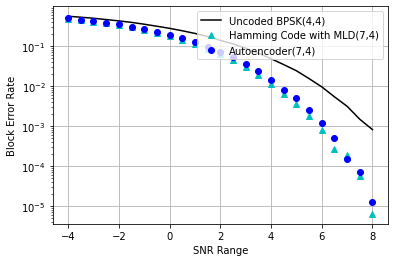

In [74]:
# ploting ber curve
import matplotlib.pyplot as plt
from scipy import interpolate
plt.plot(EbNodB_range, bpskber, 'k-',label='Uncoded BPSK(4,4)')
plt.plot(EbNodB_range, hamMLDber, 'c^',label='Hamming Code with MLD(7,4)')
plt.plot(EbNodB_range, ber, 'bo',label='Autoencoder(7,4)')
plt.yscale('log')
plt.xlabel('SNR Range')
plt.ylabel('Block Error Rate')
plt.grid()
plt.legend(loc='upper right',ncol = 1)
plt.savefig("Autoencoder(7,4).png")